In [265]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [266]:
# Parameters (EC5)
m = 0.068 # (Kg)
g = 9.81 #(m/s^2)
k = 2*3.2654e-5 #(Nm^2/A^2) 
R = 1         # resistência (Ohm)
epsilon = 0.03
# Ponto de equilíbrio
x0 = 7.3e-3                                      # posição de equilíbrio (m)
i0 = 1.0                                         # corrente de equilíbrio (A)
u0 = R * i0                                      # tensão de equilíbrio (V)


print(f"Corrente de equilíbrio i0 = {i0:.4f} A")
print(f"Tensão de equilíbrio u0 = {u0:.4f} V")

Corrente de equilíbrio i0 = 1.0000 A
Tensão de equilíbrio u0 = 1.0000 V


In [267]:
# Força magnética
def f_m(i, x):
    return (k/2) * (i**2/x**2)

# Fator Bl
def Bl(i, x):
    return f_m(i,x)/i

# Indutância (assumida constante)
def L(x):
    return 0.01  # H


In [268]:
# Ganhos do PID
Kp = 190
Ki = 20
Kd = 20

# Função do sistema dinâmico com controle PID
def f(t, y):
    i, x, v, E = y  # corrente, posição, velocidade, erro acumulado
    e = x - x0      # erro de posição
    der_e = v       # derivada do erro (dx/dt)
    int_e = E       # integral do erro acumulado

    delta_u = Kp * e + Ki * int_e + Kd * der_e
    u = u0 + delta_u

    di_dt = (u - R * i - Bl(i, x) * v) / L(x)
    dx_dt = v
    dv_dt = g - f_m(i, x) / m
    dE_dt = e

    return [di_dt, dx_dt, dv_dt, dE_dt]


In [269]:
# Condições iniciais

y0 = [i0, x0, 0.0, 0.0]  # [corrente, posição, velocidade, erro acumulado]
t0, tf = 0, 30           # intervalo de simulação
t_eval = np.linspace(t0, tf, 1000)

# Simulação numérica com Runge-Kutta 4(5)
sol = solve_ivp(f, (t0, tf), y0, t_eval=t_eval)

# Extração dos resultados
t = sol.t
i = sol.y[0]
x = sol.y[1]
v = sol.y[2]


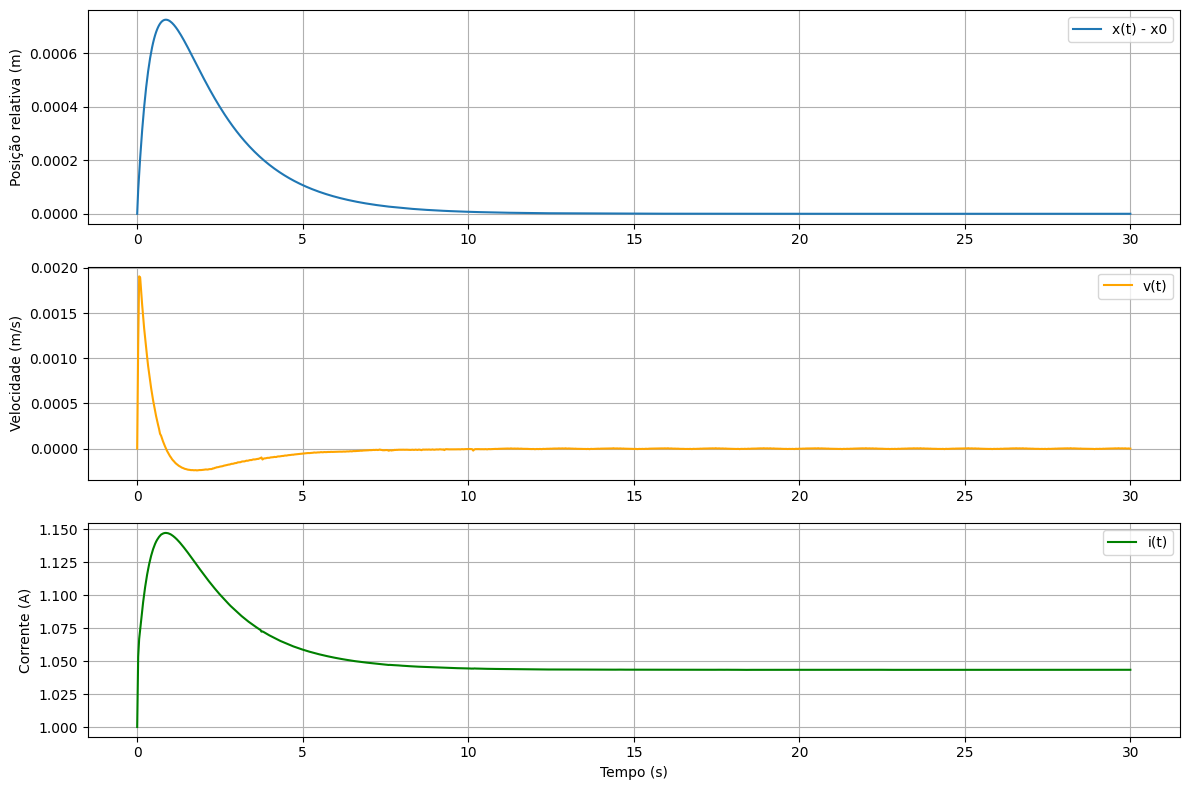

In [270]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, x - x0, label='x(t) - x0')
plt.ylabel('Posição relativa (m)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, label='v(t)', color='orange')
plt.ylabel('Velocidade (m/s)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, i, label='i(t)', color='green')
plt.xlabel('Tempo (s)')
plt.ylabel('Corrente (A)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Espaço de Fases

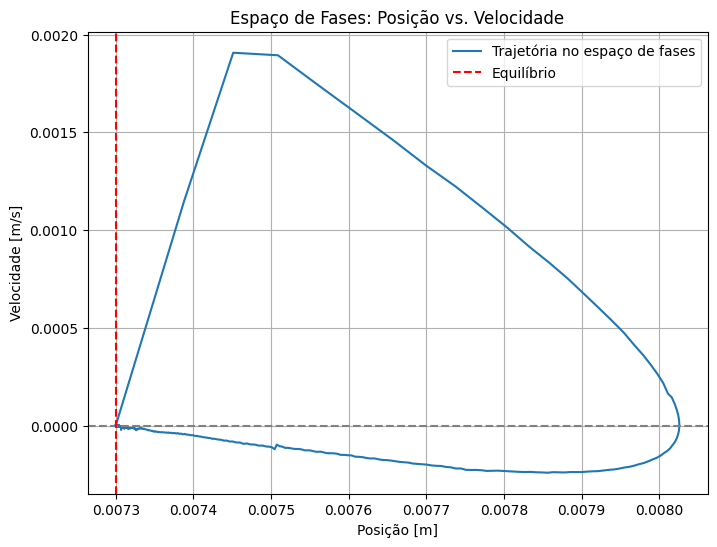

In [271]:
x_ref = x0  # Ponto de equilíbrio

# Sistema no espaço de estados
def sistema_espaco_estados(x, i):
    dx1 = x[1]  # velocidade
    dx2 = g - (f_m(i, x[0])/m)  # aceleração
    return np.array([dx1, dx2])

# Simulação com controle PID
from scipy.integrate import solve_ivp

def simular_PID_espaco_fases(x0, v0, i0, x_ref, Kp, Ki, Kd, u0, massa_esfera, R, Bl_val, L, g, f_m, n_passos, dt):
    def dinamica(t, y):
        i, x, v, erro_int = y

        erro = x_ref - x
        erro_der = -v

        # PID Controller
        delta_u = Kp * erro + Ki * erro_int + Kd * erro_der
        u = u0 + delta_u

        # Derivadas
        di_dt = (u - R * i - Bl_val * v) / L(x)
        dx_dt = v
        dv_dt = g - f_m(i, x) / massa_esfera
        dE_dt = erro

        return [di_dt, dx_dt, dv_dt, dE_dt]

    y0 = [i0, x0, v0, 0.0]
    t_span = (0, n_passos * dt)
    t_eval = np.arange(0, n_passos * dt, dt)

    sol = solve_ivp(dinamica, t_span, y0, t_eval=t_eval, method='RK45')

    # Mesmo retorno: estados em formato [n_passos, 4]
    return sol.y.T

trajetoria = simular_PID_espaco_fases(x0, 0, i0, x0, Kp, Ki, Kd, u0, m, R, Bl(i0, x0), L, g, f_m, 1000, 0.01)

# Plotar o espaço de fases
plt.figure(figsize=(8, 6))
plt.plot(x, v, label='Trajetória no espaço de fases')
plt.xlabel('Posição [m]')
plt.ylabel('Velocidade [m/s]')
plt.title('Espaço de Fases: Posição vs. Velocidade')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')      # linha de velocidade zero
plt.axvline(x0, color='r', linestyle='--', label='Equilíbrio')  # linha de posição de equilíbrio
plt.legend()
plt.show()
